# 2024-04-12 · Spikes-only connection inference

I am curious yes.  
Small lit rev synthesis:

- best method is gewoon nog steeds simpelweg cross-correlation
  (slide (binned?) spiketrains over each other for some back and front delays; and get peak height).
- transfer entropy not as good; "HOTE" of zoiets (higher order TE) van Ito et al 2011, is wel as good; maar much more expensive.
- gewone CC vindt inh connecties niet goed. Verbetering van Pastore et al 2018 ("FNCCH".),
  is simpelweg mean centering van het cross-corr signal (zodat pos en neg peaks gelijke kans krijgen in vinden van abs max).
- De Blasi et al 2019: "TSPE". Also CC based. Same perf as FNCHH. instead of mean subtraction they use an edge filter to find high or low peak.

  
So conclusion: we'll do xcorr with mean centering.  
At first I thought to take it at a fixed delay (we know which of the two is pre and post, and the delay should be ± fixed).  
But let's just do at a range, then we have nice plots that can be compared with lit.

In [46]:
include("lib/Nto1.jl")

using Revise … ✔
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔
using StatsBase … ✔


So, Nto1, same as prev:

In [141]:
N = 6500
duration = 10minutes

600

In [142]:
@time sim = Nto1AdEx.sim(N, duration);

  1.555949 seconds (21.57 k allocations: 912.269 MiB, 0.79% gc time)


No VI necessary ofc.  
(Ok there'd be time jitter on spikes maybe, dunno about calcium imaging to spikes signal processing).  
(and missed plus spurious spikes yeah. And two spikes close together in time (nonlinear summation)).

So, let's get the post and pre spiketrains.

In [143]:
length(sim.spiketimes)

2817

In [144]:
length(sim.trains[1])

1860

In [145]:
include("lib/plot.jl")

import PythonCall … ✔
import PythonPlot … ✔
using Sciplotlib … ✔
using PhDPlots … ✔


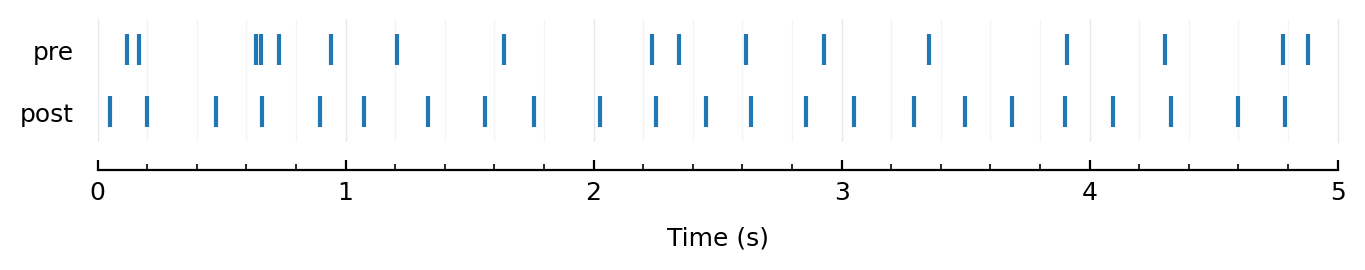

In [146]:
before(t, x) = x[x .< t]

function rasterplot_pre_post(pre, post, T = 5seconds)
    ax = newax(figsize=(8, 0.8))
    ax.eventplot(before(T, post), lineoffsets=1)
    ax.eventplot(before(T, pre),  lineoffsets=3)
    set(ax, ytype=:cat, xlabel="Time (s)")
    ax.set_yticks([1, 3], ["post", "pre"])
end
rasterplot_pre_post(sim.trains[1], sim.spiketimes);

(Interesting, this regular post spiking. Hadn't noticed that before 🙈)

And the irregular-to-regular transformation is super interesting too !!  \
Given that they have approx the same spikerate.  
Anyway.


So, time binning.  
(In principle not necessary. But then you need to bin the resulting xcorr signal, or convolve a smoothing kernel over it).

Which binsize ? (and which offset; but I'm sure everyone just takes 0 for that)

dt is 0.1 ms. At 4 Hz or 250 ms between spikes, there's 2500 timesteps between 'em.

What do the guys do?
- I see a 1 ms binsize somewhere in De Blasi 2019's text.
- Pastore et al 2018 seem to have about 100 ms (counting datapoints in their methods figure).
- Eyten et al 2004 (ref [39] of Pastore 2018, "following a known normalization approach to the CC values [39]") has 5 ms seems.

That's a big diff!
So I guess we'll make it a param and try 1, 10, 100, 1000.

(In 2022-08-05__Spiketrain-correlations, I went from 12.5 to 200)  
But that nb was not about xcorrs, just non-delayed/offset corrs. So that's why big sizes make sense.

In [67]:
x = sim.trains[1]
y = sim.spiketimes

binsize = 10ms

x = bin(x; sim.duration, binsize)
y = bin(y; sim.duration, binsize)

cor(x, y)

0.00702

Then for sliding the corr (xcorr = CC), we must decide what happens at the edges.

The normalization done (/ (Nx * Ny), num spikes in pre and post) is to account for differences in spike rate ("MFR", mean fr) between neurons; this is not the edge normalization.

So. All formules are continuous time.
Taking notation of Pastore 2018:
$$
C_{xy}(τ) = \frac{1}{\sqrt{N_x N_y}} \sum_{s=1}^{N_x} x(t_s) \ y(t_s - τ)
$$

$y$ is the "target" -- I think our 'post'.  
$x$ is the "reference" -- I think our 'pre'.\
"CC measures the frequency at which a target fires relative to the events of the reference".\

$t_s$ is the time of a spike in $x$

Say τ is 0. Taking this thing literally in continuous time, it's always gonna be 0! Nowhere do events have the exact same timing.  
But if we use the simulation time step (or some coarser binning), it's: how many timesteps they both have a spike at the same time.
(A count, cause we're summing $1·1 = 1$'s).\
Equivalently (and more literally the formula, with summing over events and up to $N_x$): how many of x's spikes have a corresponding spike at the same time in y.



Now with a positive delay τ\
(and CC is symmetric (said in Pastore but true in general, could prove but blah): $C_{xy}(τ) = C_{yx}(-τ)$.\
Ah, but not $C_{xy}(τ) = C_{xy}(-τ)$ (?)).

On the 'taking literally': yes at exactly τ=0 it'll be zero (unless, indeed the events have the exact same time). But there'll always be a τ where the overlapping spike count is 1: namelly τ = the time between a spike of x and one of y.\
So yes, in the continuous dt→0 limit, this $C_{xy}$ is a 'spike' train itself: zero everywhere and a "1" at every time-delay between every spike of x and every spike of y. (I.e. it's got (max) $N_x · N_y$ 'spikes').

(OK it could be "2" or more if there's two spike-pairs with the exact same delay).

Back to τ > 0:

So for our mental visualization (see raster plot above): x / pre train stays where it is.\
..And y train'll move forward, right?\
Numeric example to understand: if x has a spike at $t_s=1$ s,
and y one at $t=1.1$ s, then yes at positive $τ = 0.1$ s, we'll have a 'coincidence event'.

So, yes, we can mentally shift the y / post train backwards in time in the plot.

Ok, now what happens at the end. We're not gonna consider long delays yeah.  
There was a cool set of concrete numbers in .. again in Pastore 2018 :)  
"Spatio-temporal filtering procedure":  
- minimum delay of 1 ms, "compatible with fast excitatory AMPA synaptic transmission"
- maximum delay of (spatial distance between neurons) * (maximum propagation velocity of 400 mm / s)

Of course, we approx know our delay at which to expect coincidences.
Going to a plot of our PSPs / STAs, e.g. fig 23: **peak of STA at ± 6 ms**.\
(That's without artifically introduced tx delay remember).\
The max dip of the STA is at about very roughly 50 ms.\
Our (self-chosen) STA windows go up to 100 ms.\
So yeah let's take 100 ms max, at least for our mental calculation of the edge problem.\
(We could also e.g. take 20 or 40 or 60 ms).\
Also, this STA peak location thing is relevant for our pre-processing time binning of the spike trains.
We said 10 ms? Maybe take 1 ms then? Or not binning (i.e. taking 0.1 ms; we have spiketimes arrays now, not dense [0 0 0 1 0 ..] arrays).

So, the edge problem.\
If we have a max 100 ms aka 0.1 s τ.\
Then the diff between τ ≈ 0 ms and τ = 100 ms in data length to work with is:
- 10 minutes aka 600 seconds
- versus 599.9 seconds.

So yeah, we'll just not normalize at ends :)

So, if we use `cor(x,y)` of julia's StatsBase, that's Pearson correlation.  
So already some normalization right. Which one.  

... todo

In [159]:
"""
Cross correlation CC between spiketrains x ('pre' / 'reference') and y ('post' / 'target').
= C_xy(τ) of Pastore 2018 (but in discrete time).

x and y will be binned (i.e. be dense binary arrays) internally.
The output vector CC will be computed for a discrete range of time delays τ, from 0 to `max_delay`.

(Positive τ shifts y backwards in time wrt x).

If T = binsize, then τ will be: [0, 1*T, 2*T, … i*T, …, D*T]

D = max_delay / binsize.
Length of the output vector will be `D + 1` (we include i = 0 too).

For e.g. τ = 2*T, this is the shortest time between spikes that counts towards CC(τ):

x     |     s|      |      |
y     |      |      |s     |

I.e. 1T.
This is the longest, i.e. 3T:

x     |s     |      |      |
y     |      |      |     s|


CC(i) thus measures how many of x's spikes have a spike in y
somewhere from `(i-1)*T` to `(i+1)*T` further in time;
normalized by both spiketrains' number of spikes.
"""
function xcorr(x, y; duration = sim.duration, binsize = 1ms, max_delay = 50ms)
    
    Nx = length(x)
    Ny = length(y)
    f = √(Nx * Ny)  # Mean firing rate normalization factor
    # (to make xcorr funcs of high and low firing neuron-pairs comparable).

    x = bin(x; duration, binsize)
    y = bin(y; duration, binsize)
    
    D = round(Int, max_delay / binsize)  # Num delays > 0
    CC = Vector{Float64}(undef, D + 1)
    for i in 0:D
        CC[i+1] = sum(x[1+i:end] .* y[1:(end-i)]) / f
        # Say there's 10 timebins total in both signals, and `i` is e.g. 2,
        # then this reads: x[3:10], y[1:8] (Which are both 8 elements long).
    end
    return CC
end;

## 6500 inputs

In [151]:
exc = highest_firing(excitatory_inputs(sim));
t = exc[1]

SpikeTrain(58522 spikes, 97.5 Hz, [0.00467, 0.0148, 0.045, 0.0473, 0.0584, 0.0758, 0.0927, 0.106, 0.109, 0.11  …  600, 600, 600, 600, 600, 600, 600, 600, 600, 600])

In [178]:
plot_xcorr(CC; binsize, ax = newax()) = begin
    D = length(CC) - 1
    τ = (0:D) .* binsize / ms
    plot(τ, CC; ax, xlabel=L"Time after $x$ spike (ms)", ylabel=L"Probablity of $y$ spike")
end;

  0.232574 seconds (321 allocations: 709.516 MiB, 20.03% gc time)


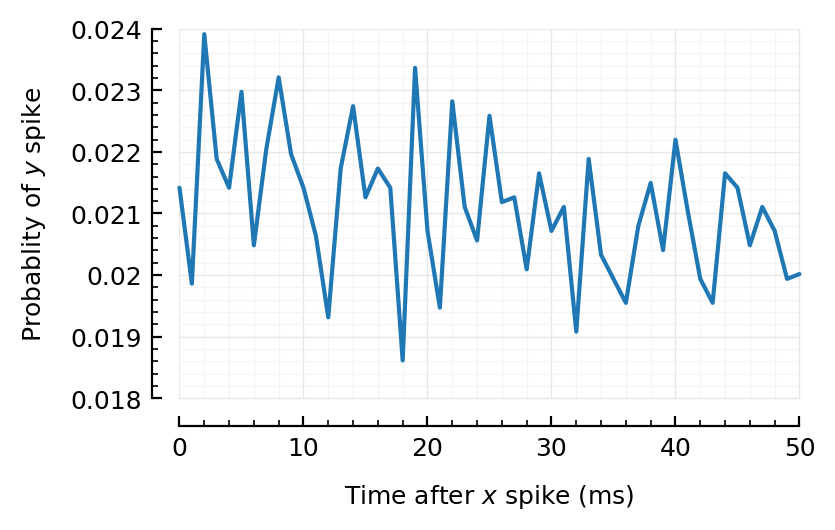

In [179]:
binsize = 1ms;

@time CC = xcorr(t.times, sim.spiketimes; binsize)
plot_xcorr(CC; binsize);

  0.001627 seconds (48 allocations: 9.157 MiB)


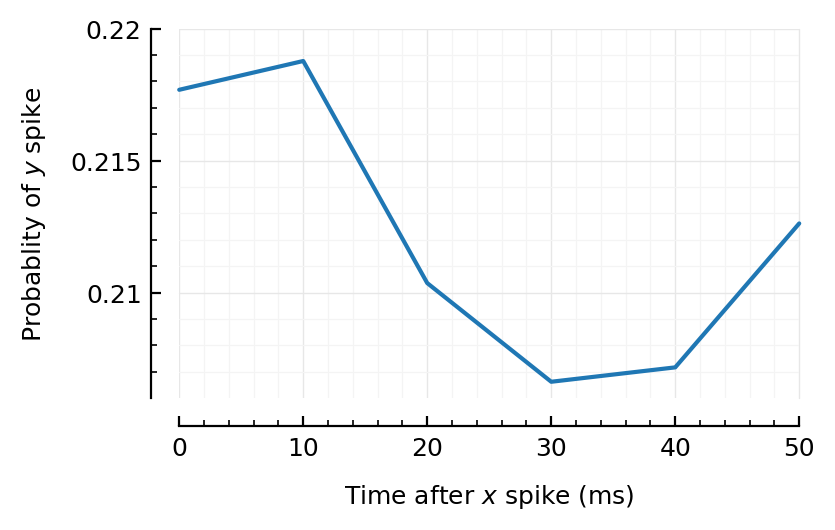

In [180]:
binsize = 10ms;

@time CC = xcorr(t.times, sim.spiketimes; binsize)
plot_xcorr(CC; binsize);

 20.234295 seconds (3.07 k allocations: 67.276 GiB, 20.32% gc time)


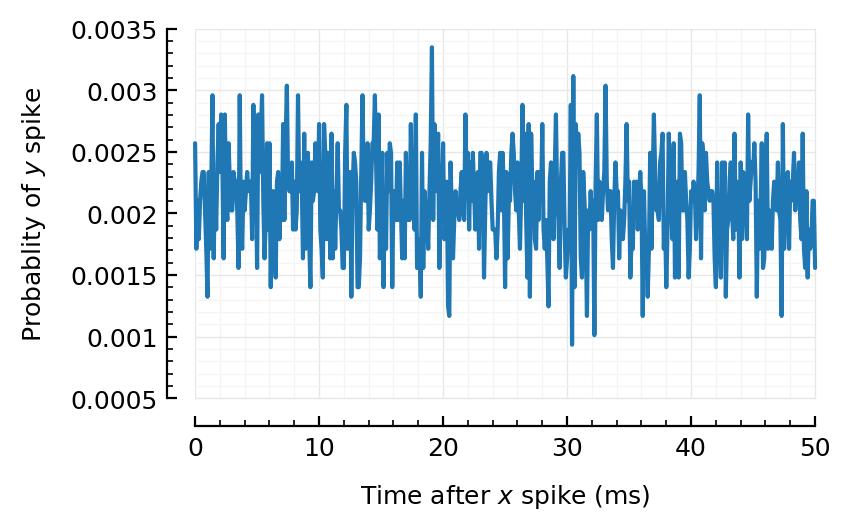

In [181]:
binsize = 0.1ms;

@time CC = xcorr(t.times, sim.spiketimes; binsize)
plot_xcorr(CC; binsize);

Huh! Even for the strongest firing (exc) input, we don't really find anything strong...

So let's do a sim with much less inputs.

## 100 inputs

In [190]:
@time sim100 = Nto1AdEx.sim(N = 100; duration);

  0.186823 seconds (371 allocations: 58.700 MiB)


In [195]:
exc100 = highest_firing(excitatory_inputs(sim100));
t = exc100[1]

SpikeTrain(8504 spikes, 14.2 Hz, [0.283, 0.343, 0.448, 0.473, 0.575, 0.584, 0.593, 0.811, 0.867, 1.11  …  600, 600, 600, 600, 600, 600, 600, 600, 600, 600])

  0.220343 seconds (344 allocations: 709.517 MiB, 17.21% gc time)


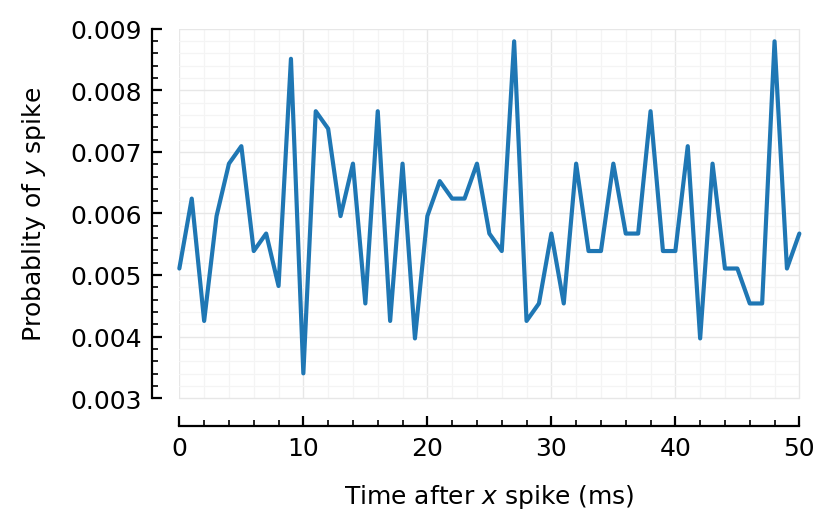

In [191]:
binsize = 1ms;

@time CC = xcorr(exc100[1].times, sim100.spiketimes; binsize)
plot_xcorr(CC; binsize);

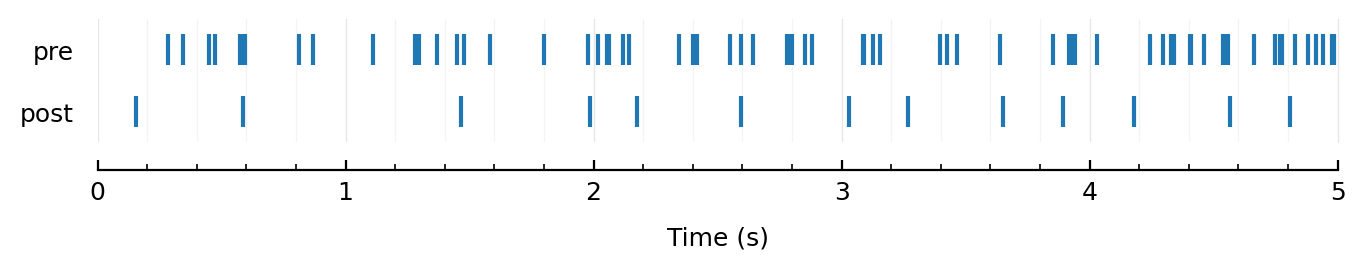

In [192]:
rasterplot_pre_post(exc100[1].times, sim100.spiketimes);

Oei. Even here not.\
Come on, kan niet he.

## 10 inputs

In [193]:
@time sim10 = Nto1AdEx.sim(N = 10; duration);

  0.168248 seconds (71 allocations: 47.296 MiB)


In [197]:
exc10 = highest_firing(excitatory_inputs(sim10));
t = exc10[1]

SpikeTrain(4073 spikes, 6.79 Hz, [0.00811, 0.0279, 0.0842, 0.0844, 0.504, 0.537, 0.648, 0.987, 1.13, 1.21  …  599, 599, 599, 599, 599, 600, 600, 600, 600, 600])

  0.207354 seconds (375 allocations: 709.517 MiB, 19.30% gc time)


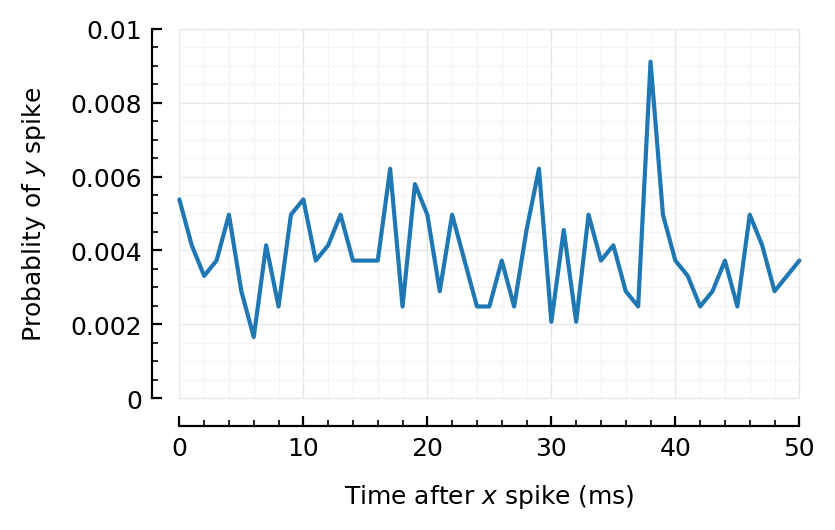

In [198]:
binsize = 1ms;

@time CC = xcorr(exc10[1].times, sim10.spiketimes; binsize)
plot_xcorr(CC; binsize);

Aha, finally :))

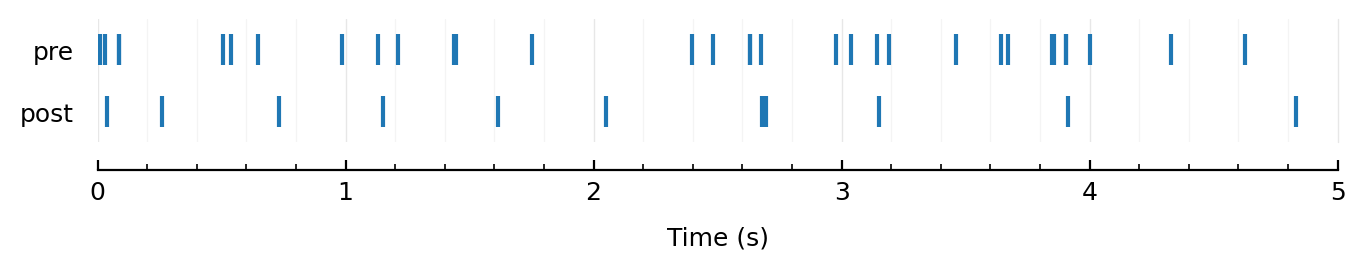

In [199]:
rasterplot_pre_post(exc10[1].times, sim10.spiketimes);

In [202]:
inh10 = highest_firing(inhibitory_inputs(sim10));
t = inh10[1]

SpikeTrain(5995 spikes, 9.99 Hz, [0.0576, 0.0778, 0.131, 0.132, 0.164, 0.528, 0.539, 0.627, 0.806, 0.834  …  599, 599, 599, 600, 600, 600, 600, 600, 600, 600])

  0.249489 seconds (344 allocations: 709.517 MiB, 32.61% gc time)


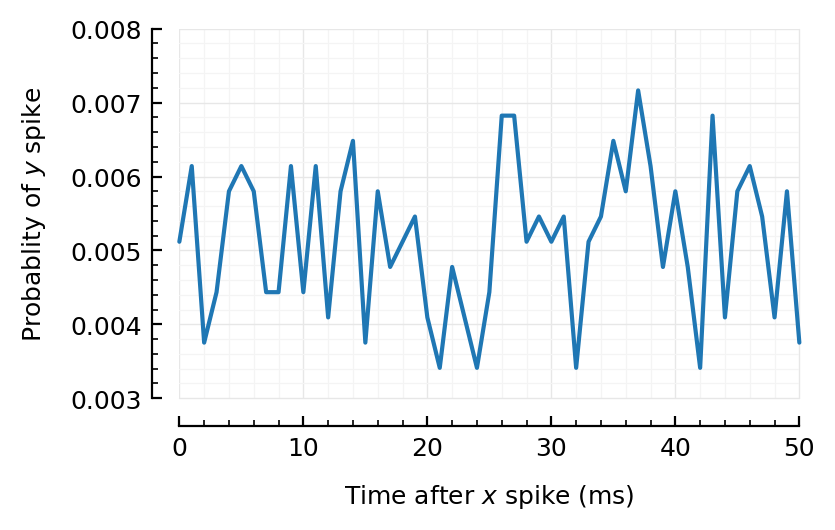

In [203]:
binsize = 1ms;

@time CC = xcorr(inh10[1].times, sim10.spiketimes; binsize)
plot_xcorr(CC; binsize);

Ok, so inh no.

Second highest exc?

  0.476494 seconds (344 allocations: 709.517 MiB, 20.63% gc time)


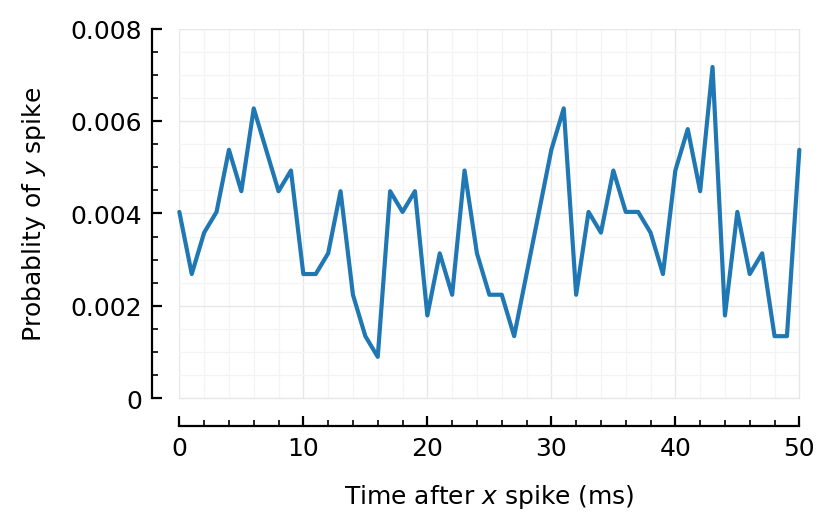

In [204]:
@time CC = xcorr(exc10[2].times, sim10.spiketimes; binsize)
plot_xcorr(CC; binsize);

Kinda, maybe.

---

Maar dit kan toch niet.\
(spike to spike / xcorr kan toch niet zo slecht zijn).

Hoe lang zijn recordings in de papers, en hoeveel inputs.